In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba
79555,Grant_Hanley,21,2,90,Norwich,Crystal Palace,0.283219,0.461424,True,1,...,1,1,6.0,1152,6558,5406,1,2020-01-01T17:30:00Z,1920,1.0
79556,Roberto_Pereyra,21,3,1,Watford,Wolverhampton Wanderers,0.471687,0.744747,True,1,...,1,2,0.0,-910,266,1176,0,2020-01-01T15:00:00Z,1920,1.0
79557,Sead_Kolasinac,21,2,68,Arsenal,Manchester United,1.428641,1.551383,True,5,...,0,2,6.0,-1322,16,1338,1,2020-01-01T20:00:00Z,1920,0.0
79558,Stuart_Armstrong,21,3,89,Southampton,Tottenham Hotspur,0.470650,2.007002,True,3,...,0,1,26.0,-95,134,229,0,2020-01-01T15:00:00Z,1920,1.0
79559,Rúben Diogo_da Silva Neves,21,3,36,Wolverhampton Wanderers,Watford,0.744747,0.471687,False,1,...,1,2,17.0,-3555,7427,10982,0,2020-01-01T15:00:00Z,1920,1.0


In [5]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [6]:
train_df.shape

(79560, 35)

In [7]:
# find the latest gameweek
last_gw = train_df['gw'][train_df['season'] == '1920'].max()

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

22

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == next_gw)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
#valid_end = train_df.index.max()

In [9]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
assists                                  int64
bonus                                    int64
bps                                      int64
clean_sheets                             int64
creativity                             float64
goals_conceded                           int64
goals_scored                             int64
ict_index                              float64
influence                              float64
own_goals                                int64
penalties_missed                         int64
penalties_sav

In [10]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']#, 'ppg_total', 'points_last_5']

In [11]:
# set dependent variable
dep_var = 'total_points'

In [12]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [16]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1218, 86)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(30, 11)
    (4): Embedding(30, 11)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=134, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [165]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


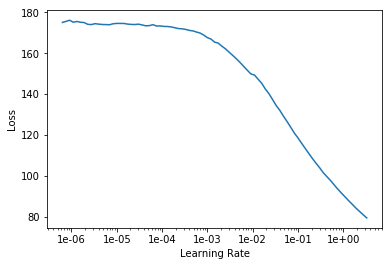

In [166]:
learn.recorder.plot()

In [ ]:
# no market value, latest half season validation
learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

In [43]:
# market value, latest half season validation
learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [18]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.673507,3.905403,1.933609,00:18
1,3.471835,3.439425,1.805674,00:07


In [19]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.455802,3.428806,1.802498,00:07


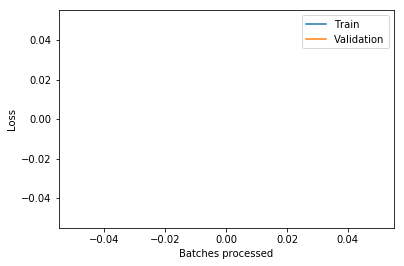

In [25]:
learn.recorder.plot_losses()

In [20]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [21]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points
63316,Alex_Smithies,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-19,38,57,0,2019-03-31T13:05:00Z,1819,NaN,0.003713
63354,Anthony_Pilkington,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-19,6,25,0,2019-03-31T13:05:00Z,1819,NaN,0.017323
63363,Aron_Gunnarsson,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,...,1,0.0,-1228,1105,2333,1,2019-03-31T13:05:00Z,1819,NaN,2.657485
63367,Ashley Darel Jazz_Richards,32,2,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-169,705,874,0,2019-03-31T13:05:00Z,1819,NaN,0.116824
63408,Bobby_Reid,32,4,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-3081,3293,6374,0,2019-03-31T13:05:00Z,1819,NaN,0.218618
63414,Brian_Murphy,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-73,175,248,0,2019-03-31T13:05:00Z,1819,NaN,0.079326
63418,Bruno_Ecuele Manga,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,...,1,0.0,1000,2500,1500,0,2019-03-31T13:05:00Z,1819,NaN,1.766862
63425,Callum_Paterson,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-4989,198,5187,0,2019-03-31T13:05:00Z,1819,NaN,0.059738
63493,Danny_Ward_2,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-71,243,314,0,2019-03-31T13:05:00Z,1819,NaN,0.086472
63503,David Junior_Hoilett,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,2,...,1,5.0,448,840,392,0,2019-03-31T13:05:00Z,1819,NaN,2.661439


In [22]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points
61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,...,5,67.0,-43453,16296,59749,0,2019-02-27T20:00:00Z,1819,NaN,9.906204
63182,Mohamed_Salah,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,2,...,1,66.0,-37072,46372,83444,0,2019-03-17T14:15:00Z,1819,NaN,9.833608
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,...,5,97.0,71136,83818,12682,0,2019-04-26T19:00:00Z,1819,NaN,9.118816
65818,Mohamed_Salah,35,3,90,Liverpool,Cardiff City,2.177887,0.183890,False,6,...,0,55.0,-23964,33993,57957,0,2019-04-21T15:00:00Z,1819,NaN,9.052775
62786,Mohamed_Salah,30,3,90,Liverpool,Burnley,2.177887,0.449442,True,5,...,4,60.0,-75411,16257,91668,0,2019-03-10T12:00:00Z,1819,NaN,9.033655
58652,Mohamed_Salah,23,3,90,Liverpool,Crystal Palace,2.177887,0.634856,True,15,...,4,68.0,317868,330481,12613,0,2019-01-19T15:00:00Z,1819,NaN,8.915307
67748,Mohamed_Salah,38,3,90,Liverpool,Wolverhampton Wanderers,2.177887,0.388177,True,3,...,2,63.0,-123436,35332,158768,0,2019-05-12T14:00:00Z,1819,NaN,8.835230
60486,Mohamed_Salah,26,3,90,Liverpool,Bournemouth,2.177887,0.418108,True,8,...,3,63.0,15794,59425,43631,0,2019-02-09T15:00:00Z,1819,NaN,8.770961
59235,Mohamed_Salah,24,3,90,Liverpool,Leicester City,2.177887,0.796050,True,2,...,1,40.0,145798,156027,10229,0,2019-01-30T20:00:00Z,1819,NaN,8.645909
59058,Heung-Min_Son,24,3,90,Tottenham Hotspur,Watford,1.983109,0.412301,True,9,...,2,71.0,28916,104589,75673,0,2019-01-30T20:00:00Z,1819,NaN,8.619761


In [23]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.032894134521484

In [24]:
prev_pt_mean = np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])
prev_pt_mean

4.707

In [25]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [26]:
remaining_season_df.head(50)
#remaining_season_df[remaining_season_df.player == 'Trent_Alexander-Arnold']

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,24,West Ham United,Liverpool,Aaron_Cresswell,2,4.7,1.00,True,0.695090,2.467285,1920,90.000000
1,24,West Ham United,Liverpool,Angelo_Ogbonna,2,4.5,1.00,True,0.695090,2.467285,1920,67.500000
2,24,West Ham United,Liverpool,Arthur_Masuaku,2,4.2,1.00,True,0.695090,2.467285,1920,24.250000
3,24,West Ham United,Liverpool,Pablo_Zabaleta,2,4.2,1.00,True,0.695090,2.467285,1920,22.500000
4,24,West Ham United,Liverpool,Ryan_Fredericks,2,4.5,1.00,True,0.695090,2.467285,1920,90.000000
5,24,West Ham United,Liverpool,Issa_Diop,2,4.4,1.00,True,0.695090,2.467285,1920,23.000000
6,24,West Ham United,Liverpool,Fabián_Balbuena,2,4.3,1.00,True,0.695090,2.467285,1920,90.000000
7,24,West Ham United,Liverpool,Winston_Reid,2,3.9,1.00,True,0.695090,2.467285,1920,0.000000
8,24,West Ham United,Liverpool,Ben_Johnson,2,4.0,1.00,True,0.695090,2.467285,1920,0.000000
9,24,West Ham United,Liverpool,Marko_Arnautovic,4,7.0,0.00,True,0.695090,2.467285,1920,0.000000


In [27]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [28]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [29]:
# train as before
learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [30]:
learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [42]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [51]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
pred_pt_mean

5.033751487731934

In [31]:
while True:
    # instatiate new tabular learner
    learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)
    
    # train as before
    learn.fit_one_cycle(2, 1e-2, wd=0.2)
    learn.fit_one_cycle(1, 1e-3, wd=0.2)

    # get predictions
    test_preds=learn.get_preds(DatasetType.Test)
    remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]
    
    # check mean of top predictions to see if it's reasonably close to previous season's actuals
    # re-run if not - not ideal but at the moment the training often over-predicts top players
    pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
    
    if abs((prev_pt_mean - pred_pt_mean) / prev_pt_mean) < 0.05:
        print("Mean of top 1000 predictions: {:.4}".format(pred_pt_mean))
        break
    else:
        print("retraining...")

Mean of top 1000 predictions: 4.66


In [32]:
remaining_season_df.shape

(10022, 13)

In [33]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
1647,27,Liverpool,West Ham United,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.695090,1920,84.75,9.848035
3344,33,Liverpool,Aston Villa,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.532021,1920,84.75,9.652107
2758,31,Liverpool,Crystal Palace,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.461424,1920,84.75,9.530848
2233,29,Liverpool,Bournemouth,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.723080,1920,84.75,9.167990
7040,28,Liverpool,Watford,Mohamed_Salah,3,12.3,1.0,False,2.467285,0.471687,1920,84.75,9.018301
1032,25,Liverpool,Southampton,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.470650,1920,84.75,8.914968
3938,35,Liverpool,Burnley,Mohamed_Salah,3,12.3,1.0,True,2.467285,0.391345,1920,84.75,8.880689
6403,26,Liverpool,Norwich,Mohamed_Salah,3,12.3,1.0,False,2.467285,0.283219,1920,84.75,8.771534
421,23,Liverpool,Manchester United,Mohamed_Salah,3,12.3,1.0,True,2.467285,1.551383,1920,84.75,8.373549
9950,38,Liverpool,Newcastle United,Mohamed_Salah,3,12.3,1.0,False,2.467285,0.558415,1920,84.75,8.247970


In [34]:
# rename previous week's predictions file
# generate previous week's filename
last_gw = next_gw - 1
filename = 'predictions_gw' + str(last_gw) + '.csv'
! mv predictions.csv $filename

In [35]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')